# Short-term Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, Model
from scipy.fftpack import fft, ifft, fftfreq

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [144]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [145]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('flow', 'TA02_GP101'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('wind', 'Wx'),
    ('wind', 'Wy'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'hourofday')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [146]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
              TA02_GP101          11
state         TA01_output         15
              TA02_output         14
temperatures  TA01_GT10X_GM10X    14
              DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      11
              DC_GT104_GM104      11
              DC_GT401_GM401      13
              TA01_GT401_GM401    13
              TA02_GT401_GM401    12
              DC_GT301_damped     12
              DC_GT301_outdoor    12
humidity      TA01_GT10X_GM10X    15
              DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      12
              DC_GT104_GM104      10
              DC_GT401_GM401      14
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  3
              gsi_deriv            3
              vol                  3
              vol_deriv            3
wind          Wx             

In [147]:
# remove single NAN
data = data.dropna(how='any')

In [148]:
cols = [
    'DC_GT101_GM101',
    'DC_GT102_GM102',
    'DC_GT103_GM103',
    'DC_GT104_GM104'
]

for col in cols:
    data[('flag', col)] = (((data.temperatures[col] - data.temperatures[col].shift(1)) < -1) \
                            & ((data.humidity[col] - data.humidity[col].shift(1)) > 5)) \
                            | (data.humidity[col] > 70)

    hrs = data.groupby(['month', 'day', 'hour']).sum()[('flag', col)] > 0
    hrsDrop = hrs[hrs == 1].index.values
    mask = np.array([hr not in list(hrsDrop) for hr in data.index.droplevel(-1).droplevel(-1).values])
    data = data[mask]
    
    hrs = data.groupby(['month', 'day', 'hour']).var()[('humidity', col)] > 40
    hrsDrop = hrs[hrs == 1].index.values
    mask = np.array([hr not in list(hrsDrop) for hr in data.index.droplevel(-1).droplevel(-1).values])
    data = data[mask]
    
#     days = data.groupby(['month', 'day']).sum()[('flag', col)] > 0
#     daysDrop = days[days == 1].index.values
#     mask = np.array([day not in list(daysDrop) for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
    

# Feature engineering

### DC-temp scaling

In [149]:
# ta01_min = 1784.75
# ta01_max = 5173.86

# ta02_min = 0.0
# ta02_max = 5248.95

In [150]:
ta01_min = 35
ta01_max = 75

ta02_min = 0
ta02_max = 85

In [151]:
# data[('flow', 'TA01_minmax')] = (data.flow.TA01_GP101 - ta01_min) / (ta01_max - ta01_min)
# data[('flow', 'TA02_minmax')] = (data.flow.TA02_GP101 - ta02_min) / (ta02_max - ta02_min)

# data[('temperatures', 'DC_GT401_GM401_scaled')] = data.temperatures.DC_GT401_GM401 * data.flow.TA01_minmax
# data[('temperatures', 'TA01_GT401_GM401_scaled')] = data.temperatures.TA01_GT401_GM401 * data.flow.TA01_minmax
# data[('temperatures', 'DC_GT301_damped_scaled')] = data.temperatures.DC_GT301_damped * data.flow.TA02_minmax

data[('state', 'TA01_output_minmax')] = (data.state.TA01_output - ta01_min) / (ta01_max - ta01_min)
data[('state', 'TA02_output_minmax')] = (data.state.TA02_output - ta02_min) / (ta02_max - ta02_min)

data[('temperatures', 'DC_GT401_GM401_scaled')] = data.temperatures.DC_GT401_GM401 * data.state.TA01_output_minmax
data[('temperatures', 'TA01_GT401_GM401_scaled')] = data.temperatures.TA01_GT401_GM401 * data.state.TA01_output_minmax
data[('temperatures', 'DC_GT301_damped_scaled')] = data.temperatures.DC_GT301_damped * data.state.TA02_output_minmax

In [152]:
data[('temperatures', 'TA_inflow')] = data.temperatures.TA01_GT401_GM401_scaled + data.temperatures.DC_GT301_damped_scaled

## Split TRAIN / TEST

In [670]:
## Randomly select days for trainin and testing
days = data.groupby(['month', 'day'], sort=False).count().index.values

# get number of days f. testing / training
train_frac = 0.95
train_n = int(len(days) * train_frac)
test_n = len(days) - train_n

# split dataset
#np.random.shuffle(days)
mask = np.array([day in list(days[:train_n]) for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
data_train = data.loc[mask].copy()
data_test = data.loc[~mask].copy()

# del data

## NOISE reduction

### FFT f. TRAIN data

In [671]:
# cols = [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
#     ('temperatures', 'DC_GT401_GM401'),
#     ('temperatures', 'TA01_GT401_GM401'),
# #     ('temperatures', 'DC_GT301_outdoor'),
# #     ('temperatures', 'DC_GT301_damped'),
#     ('humidity', 'DC_GT102_GM102'),
#     ('humidity', 'DC_GT103_GM103'),
#     ('humidity', 'DC_GT104_GM104'),
# ]

# for col in cols:
# #     sig_fft = fft(data.humidity[col].values)
#     sig_fft = fft(data_train[col].values)
#     sig_fft_filtered = sig_fft.copy()
#     sig_fft_noise = sig_fft.copy()
    
#     #
#     freq = fftfreq(len(data_train), d=1/10)
#     cut_off = 1
    
#     sig_fft_filtered[np.abs(freq) > cut_off] = 0
#     sig_fft_noise[np.abs(freq) <= cut_off] = 0
    
#     # get the filtered signal in time domain
#     filtered = ifft(sig_fft_filtered)
#     noise = ifft(sig_fft_noise)
    
# #     plt.plot(data_train[col].values[-50:])
# #     plt.plot(filtered[-50:])
# #     plt.show()
# #     break
    
#     # put in data
# #     data.humidity.loc[:, col + '_noise'] = data.humidity[col]
#     data_train.loc[:, col] = filtered

In [672]:
# cols = [
#     (('temperatures', 'DC_GT102_GM102'), 4),
#     (('temperatures', 'DC_GT103_GM103'), 4),
#     (('temperatures', 'DC_GT104_GM104'), 4),
# #     (('temperatures', 'DC_GT401_GM401'), 3), #3),
#     (('temperatures', 'TA01_GT401_GM401'), 3), #3),
#     (('temperatures', 'TA01_GT401_GM401_scaled'), 3), #3),
#     (('temperatures', 'DC_GT301_outdoor'), 4),
#     (('temperatures', 'DC_GT301_damped'), 4),
#     (('temperatures', 'DC_GT301_damped_scaled'), 4),
#     (('humidity', 'DC_GT102_GM102'), 4),
#     (('humidity', 'DC_GT103_GM103'), 4),
#     (('humidity', 'DC_GT104_GM104'), 4),
# ]

# for colSpec in cols:
#     for day in data_train.groupby(['month', 'day']).count().index.values:
#         # apply KALMAN filter to measurements
#         col = colSpec[0]
#         varExp = colSpec[-1]

#         # get data
#         X = data_train.loc[day, col].values
#         n = len(X)

#         # process variance, measurement variance
#         Q = 1e-5
#         R = 0.1**varExp

#         xhat=np.zeros(n)      # a posteri estimate of x
#         P=np.zeros(n)         # a posteri error estimate
#         xhatminus=np.zeros(n) # a priori estimate of x
#         Pminus=np.zeros(n)    # a priori error estimate
#         K=np.zeros(n)         # gain or blending factor

#         # intial guesses
#         xhat[0] = X[0]
#         P[0] = 1

#         for k in range(1,n):
#             # time update
#             xhatminus[k] = xhat[k-1]
#             Pminus[k] = P[k-1]+Q

#             # measurement update
#             K[k] = Pminus[k]/( Pminus[k]+R )
#             xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
#             P[k] = (1-K[k])*Pminus[k]

#         data_train.loc[day, col] = xhat

In [673]:
### create "better" estimate of temperature var, w. proper avg.
data_train[('temperatures', 'TA01_GT10X_GM10X')] = data_train.temperatures[[
#     ('DC_GT101_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

# # adjust for setpoint change
# data_train[('temperatures', 'TA01_GT10X_GM10X')] += (20.0 - data_train[('setpoints', 'TA01_GT10X_GM10X')])

In [674]:
### create "better" estimate of humidity var, w. proper avg.
data_train[('humidity', 'TA01_GT10X_GM10X')] = data_train.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

### KALMAN f. TEST data

In [675]:
# cols = [
# #     (('temperatures', 'TA01_GT10X_GM10X'), 3)
# #     (('temperatures', 'DC_GT102_GM102'), 3),
# #     (('temperatures', 'DC_GT103_GM103'), 3),
# #     (('temperatures', 'DC_GT104_GM104'), 3),
# #     (('temperatures', 'DC_GT401_GM401'), 3), #3),
# #     (('temperatures', 'DC_GT401_GM401_scaled'), 3), #3),
# #     (('temperatures', 'TA01_GT401_GM401'), 3), #3),
# #     (('temperatures', 'TA01_GT401_GM401_scaled'), 3), #3),
# #     (('temperatures', 'DC_GT301_outdoor'), 3),
# #     (('temperatures', 'DC_GT301_damped'), 3),
# #     (('temperatures', 'DC_GT301_damped_scaled'), 3),
# #     (('humidity', 'DC_GT102_GM102'), 3),
# #     (('humidity', 'DC_GT103_GM103'), 3),
# #     (('humidity', 'DC_GT104_GM104'), 3),
# ]

# for colSpec in cols:
#     for day in data_test.groupby(['month', 'day']).count().index.values:
#         # apply KALMAN filter to measurements
#         col = colSpec[0]
#         varExp = colSpec[-1]

#         # get data
#         X = data_test.loc[day, col].values
#         n = len(X)

#         # process variance, measurement variance
#         Q = 1e-5
#         R = 0.1**varExp

#         xhat=np.zeros(n)      # a posteri estimate of x
#         P=np.zeros(n)         # a posteri error estimate
#         xhatminus=np.zeros(n) # a priori estimate of x
#         Pminus=np.zeros(n)    # a priori error estimate
#         K=np.zeros(n)         # gain or blending factor

#         # intial guesses
#         xhat[0] = X[0]
#         P[0] = 1

#         for k in range(1,n):
#             # time update
#             xhatminus[k] = xhat[k-1]
#             Pminus[k] = P[k-1]+Q

#             # measurement update
#             K[k] = Pminus[k]/( Pminus[k]+R )
#             xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
#             P[k] = (1-K[k])*Pminus[k]

# #         plt.plot(data_test.loc[day, col].values)
# #         plt.plot(xhat)
# #         plt.show()
# #         break
            
#         data_test.loc[day, col] = xhat

In [676]:
# cols = [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
# ]

# for col in cols:
#     for day in data_test.groupby(['month', 'day']).count().index.values:
        
#         alpha = 0.9
        
#         X = data_test.loc[day, col].values
#         n = len(X)
        
#         x = X[0]
#         xhat = [x.copy()]

#         for k in range(1,n):
#             x = alpha * x + (1 - alpha) * X[k]
#             xhat.append(x)
            
#         plt.plot(data_test.loc[day, col].values[-500:])
#         plt.plot(xhat[-500:])
#         plt.show()
#         break
            
#         data_test.loc[day, col] = xhat

In [677]:
### create "better" estimate of temperature var, w. proper avg.
data_test[('temperatures', 'TA01_GT10X_GM10X')] = data_test.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)


# # adjust for setpoint change
# data_test[('temperatures', 'TA01_GT10X_GM10X')] += (20.0 - data_test[('setpoints', 'TA01_GT10X_GM10X')])

In [678]:
### create "better" estimate of humidity var, w. proper avg.
data_test[('humidity', 'TA01_GT10X_GM10X')] = data_test.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [679]:
# fig, ax = plt.subplots()

# # ax.plot(data.temperatures.TA01_GT10X_GM10X.values[-12500:])
# ax.plot(data.temperatures.TA01_GT10X_GM10X.values[-10000:-9500])
# # ax.plot(data.temperatures.DC_GT102_GM102.values[-12500:-9000])
# # ax.plot(data.temperatures.DC_GT103_GM103.values[-12500:-9000])
# # ax.plot(data.temperatures.DC_GT301_damped_scaled.values[-12500:])

# ax2 = ax.twinx()
# ax2.plot(data.temperatures.TA01_GT401_GM401.values[-10000:-9500], 'r')
# # ax2.plot(data.sun.gsi.values[-12500:], 'r')
# plt.show()

### Reduce to M-min observations

In [680]:
# set min per observation
m = 5

In [681]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
idxObj = zip(
    data_train.index.get_level_values(0),
    data_train.index.get_level_values(1),
    data_train.index.get_level_values(2),
    data_train.index.get_level_values(3) // m
)

index = pd.MultiIndex.from_tuples(
    tuples=idxObj,
    names=['month', 'day', 'hour', 'minute']
)

data_train.index = index
data_train = data_train.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

In [682]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
idxObj = zip(
    data_test.index.get_level_values(0),
    data_test.index.get_level_values(1),
    data_test.index.get_level_values(2),
    data_test.index.get_level_values(3) // m
)

index = pd.MultiIndex.from_tuples(
    tuples=idxObj,
    names=['month', 'day', 'hour', 'minute']
)

data_test.index = index
data_test = data_test.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

### Normalization

In [683]:
# Define model variables
model_vars = [
#     ('temperatures', 'TA_inflow'),
#     ('state', 'TA01_output'),
#     ('state', 'TA02_output'),
#     ('flow', 'TA01_GP101'),
#     ('flow', 'TA02_GP101'),
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
#     ('temperatures', 'TA01_GT401_GM401_scaled'),
#     ('temperatures', 'DC_GT301_damped_scaled'),
#     ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
#     ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
#     ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
#     ('sun', 'vol_deriv'),
#     ('wind', 'Wx'),
#     ('wind', 'Wy'),
#     ('time', 'minofday'),
#     ('time', 'dayofyear')
]

# filter data
data_train = data_train[model_vars].copy()
data_test = data_test[model_vars].copy()

In [684]:
col_params = {}
for col in data_train.columns:
    cat, var = col
    
#     if cat == 'temperatures' and var == 'TA01_GT10X_GM10X':
#         continue
    
    min_val = data_train[col].min()
    max_val = data_train[col].max()
    
    # normalize
    mean = data_train[col].mean()
    std = data_train[col].std()
    
    data_train[col] = (data_train[col] - mean) / std
    data_test[col] = (data_test[col] - mean) / std
    
#     # make positive
#     min_val = data_train[col].min()
#     data_train[col] = data_train[col] + abs(min(0, min_val))
#     min_val = max(0, min_val)
#     max_val = data_train[col].max()
#     data_train[col] = (data_train[col] - min_val) / (max_val - min_val)
    
#     data_test[col] = data_test[col] + abs(min(0, min_val))
#     data_test[col] = (data_test[col] - min_val) / (max_val - min_val)
#     data_test[col] = data_test[col].apply(lambda val: max(val, 0.0))
# #     data_test[col] = data_test[col].apply(lambda val: max(min(val, 1.0), 0.0))
    
    col_params[col] = {
        'mean':mean,
        'std':std,
        'max':max_val,
        'min':min_val
    }

In [685]:
# ta01_max, ta01_min = col_params[('state', 'TA01_output')]['max'], col_params[('state', 'TA01_output')]['min']
# ta02_max, ta02_min = col_params[('state', 'TA02_output')]['max'], col_params[('state', 'TA02_output')]['min']

## Data preparation

In [686]:
t_steps = 12    # 5 x 2 = 10-min predictions
n_steps = 18    # 5 x 12 = 60-min backwards look

In [687]:
# targets_train = data_train[('temperatures', 'TA01_GT10X_GM10X')].copy()
# targets_test = data_test[('temperatures', 'TA01_GT10X_GM10X')].copy()

In [688]:
targets_train = pd.concat([data_train.pop(col) for col in [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
]], axis=1)
# targets_train = (targets_train - targets_train.shift(t_steps)) * 10

targets_test = pd.concat([data_test.pop(col) for col in [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
]], axis=1)
# targets_test = (targets_test - targets_test.shift(t_steps)) * 10

In [689]:
# targets_train *= 10
# targets_test *= 10

In [690]:
temps_train = targets_train[:-n_steps]#.values
temps_test = targets_test[:-n_steps]#.values

### Create sequences

In [691]:
def date_flagger(data, n_steps):
    # get flagged datesvalues
#     data['minute'] = data.index.get_level_values(3).values    
#     data['date_flag'] = data.minute - data.minute.shift(n_steps) != (n_steps)

    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [692]:
def seq_maker_single(data, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    
    return sequences

def seq_maker(data, targets, temps, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask].values
    temps = temps[mask].values
    
    return sequences, targets, temps

In [693]:
# make sequences
sequences_train, targets_train, temps_train = seq_maker(data_train, targets_train, temps_train, n_steps)
sequences_test, targets_test, temps_test = seq_maker(data_test, targets_test, temps_test, n_steps)

In [694]:
sequences_masked = sequences_test.copy()

# mask_len = t_steps+1
mask_len = 10
for t in range(1, mask_len):
    sequences_masked[:, -t, :] = sequences_masked[:, -(t_steps+1), :]

In [695]:
# shuffle training data randomly
idxs = np.arange(len(targets_train))
np.random.shuffle(idxs)

sequences_train = sequences_train[idxs]
targets_train = targets_train[idxs]
temps_train = temps_train[idxs]

## Define Recurrent NN

In [696]:
tf.keras.backend.clear_session()

In [697]:
# class Sampling(layers.Layer):
#     """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

#     def call(self, inputs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.random.normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# inputs = layers.Input(shape=(sequences_train.shape[1], sequences_train.shape[2]))

# encoder = layers.GRU(units=128, recurrent_dropout=0.5, return_sequences=True, return_state=False)(inputs)
# encoder = layers.GRU(units=64, recurrent_dropout=0.5, return_sequences=True, return_state=False)(encoder)
# _, encoder = layers.GRU(units=32, recurrent_dropout=0.5, return_sequences=False, return_state=True)(encoder)

# state = layers.LayerNormalization()(encoder)

# latent_dim = 4
# z_mean = layers.Dense(latent_dim, name="z_mean")(state)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(state)
# z = Sampling()([z_mean, z_log_var])
# encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# # output = layers.Dense(units=1, activation=None, use_bias=False)(z)
# model = Model(inputs, z)


In [698]:
inputs = layers.Input(shape=(sequences_train.shape[1], sequences_train.shape[2]))
inputs = layers.LayerNormalization()(inputs)

_, _, encoder = layers.LSTM(units=32, recurrent_dropout=0.5, return_sequences=True, return_state=True)(inputs)
# _, _, encoder = layers.LSTM(units=16, recurrent_dropout=0.5, return_sequences=False, return_state=True)(encoder)
encoder = layers.LayerNormalization()(encoder)
# encoder = layers.Dense(units=16, activation='relu')(encoder)
# encoder = layers.LayerNormalization()(encoder)
# encoder = layers.Dense(units=32, activation='relu')(encoder)
# encoder = layers.LayerNormalization()(encoder)

# ta_input = layers.Input(shape=(sequences_train.shape[1], 2))
# ta_flattened = layers.Flatten()(ta_input)

# output = layers.Concatenate()([encoder, ta_flattened])
output = layers.Dense(units=1, activation=None, use_bias=True)(encoder)


encoded = Model(inputs, encoder)
model = Model(inputs, output)

In [699]:
lr = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), loss='mse')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 18, 5)]           0         
                                                                 
 lstm (LSTM)                 [(None, 18, 32),          4864      
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
 layer_normalization_1 (Laye  (None, 32)               64        
 rNormalization)                                                 
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________

In [700]:
# model2 = tf.keras.models.load_model(save_path + 'temp_diff_model_v103')
# model2.summary()

In [701]:
# # copy weigths from pre-trained
# for idx, layer in enumerate(model.layers):
#     layer.set_weights(model2.layers[idx].get_weights())

In [702]:
sequences_train[:, :, :2].shape

(17809, 18, 2)

In [703]:
trainHist = model.fit(
#     [sequences_train, temps_train],
#     [sequences_train, sequences_train[:, :, :2]],
    sequences_train,
    targets_train,
    epochs=50,
    batch_size=128,
#     validation_split=0.0,
#     validation_data = ([sequences_test, temps_test], targets_test),
    validation_data = (sequences_test, targets_test),
#     validation_data = ([sequences_test, sequences_test[:, :, :2]], targets_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=False),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/50
140/140 [==============================] - 5s 22ms/step - loss: 0.7257 - val_loss: 3.4173
Epoch 2/50
140/140 [==============================] - 3s 20ms/step - loss: 0.5121 - val_loss: 2.7969
Epoch 3/50
140/140 [==============================] - 3s 20ms/step - loss: 0.4598 - val_loss: 2.2947
Epoch 4/50
140/140 [==============================] - 3s 20ms/step - loss: 0.4211 - val_loss: 1.7963
Epoch 5/50
140/140 [==============================] - 3s 20ms/step - loss: 0.3966 - val_loss: 1.5564
Epoch 6/50
140/140 [==============================] - 3s 20ms/step - loss: 0.3760 - val_loss: 1.2899
Epoch 7/50
140/140 [==============================] - 3s 20ms/step - loss: 0.3592 - val_loss: 1.1548
Epoch 8/50
140/140 [==============================] - 3s 20ms/step - loss: 0.3481 - val_loss: 1.0676
Epoch 9/50
140/140 [==============================] - 3s 20ms/step - loss: 0.3358 - val_loss: 0.9943
Epoch 10/50
140/140 [==============================] - 3s 20ms/step - loss: 0.3284 - val_lo

KeyboardInterrupt: 

In [448]:
# model_name = 'temp_diff_model_vXXX'
# model.save(save_path + model_name)

INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\temp_diff_model_vXXX\assets


INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\temp_diff_model_vXXX\assets


In [247]:
# model = tf.keras.models.load_model(save_path + 'temp_diff_model_v202')
# model.summary()

In [248]:
# preds_dist = np.squeeze(encoder.predict(sequences_masked))
# pred = preds_dist[:, 0, :]

# z1_mean, z1_logvar, z1 = pred[:, 0]
# z2_mean, z2_logvar, z2 = pred[:, 1]

# plt.plot(targets_test[:100])
# plt.plot(preds_dist[0, :100, :])

In [704]:
# preds = np.squeeze(model.predict([sequences_test, temps_test]))
preds = np.squeeze(model.predict(sequences_test))
preds_masked = np.squeeze(model.predict(sequences_masked))

35/35 [==============================] - 0s 5ms/step


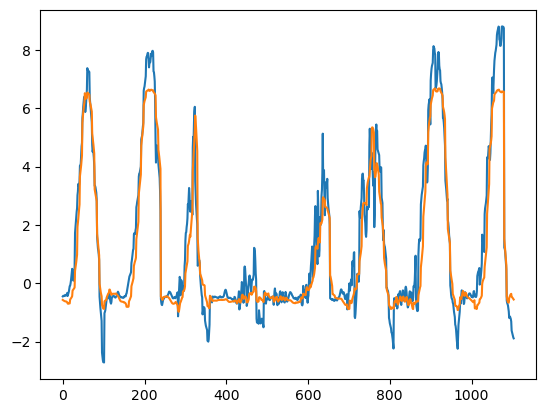

In [705]:
# plt.plot(targets_test[-3000:, 0])
# plt.plot(targets_test[-3000:, 1])
plt.plot(targets_test[-2000:])
plt.plot(preds[-2200:])
# plt.plot(preds_masked[-2000:])
plt.show()

## PCA on ecoded stataes

In [706]:
from sklearn.decomposition import PCA

decomposer = PCA(n_components=3)

In [707]:
encodings = encoded.predict(sequences_masked)
decomposed = decomposer.fit_transform(X=encodings)

35/35 [==============================] - 0s 5ms/step


In [708]:
plt_data = pd.DataFrame(
    data=np.hstack((decomposed, targets_test)),
    columns=['pca_1', 'pca_2', 'pca_3', 'temps']
)

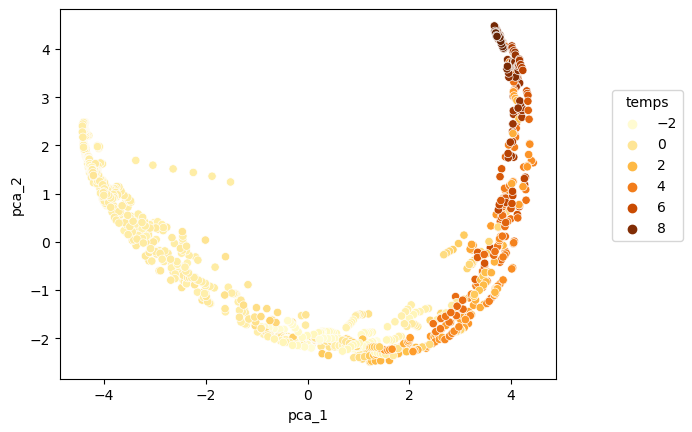

In [709]:
ax = sns.scatterplot(
    data=plt_data,
    x='pca_1',
    y='pca_2',
    hue='temps',
    palette='YlOrBr'
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 0.8))


## Heatmaps

In [657]:
# ## preds_df = pd.DataFrame(data=[targets_test / 10, np.squeeze(preds) / 10]).T
# preds_df = pd.DataFrame(data=[np.squeeze(targets_test), np.squeeze(preds), np.squeeze(preds_masked)]).T
# preds_df.columns = ['True', 'Preds', 'Masked']
# # preds_df.index = data.time.date.iloc[-5760:]

# ax = sns.relplot(
#     data=preds_df, #.iloc[:12000],
#     kind='line',
#     palette=sns.color_palette('bright')[1:4],
#     linewidth=1.5,
#     markers=False,
#     dashes=False
# )

# # ax.set_xticklabels(step=2)
# sns.move_legend(ax, loc='upper right', frameon=True, bbox_to_anchor=(0.9, 0.9))
# plt.xlim(0, 800)
# plt.ylim(-5, 10)
# plt.xlabel('$t$')
# # plt.ylabel('C$^{\circ}$', rotation=0, labelpad=20)
# plt.ylabel('$\sigma$', rotation=0, labelpad=10)
# plt.title('Temperature predictions (60 mins.)')
# # plt.savefig(plot_path + 'temp_diff_model_preds.png', bbox_inches='tight', dpi=200)
# plt.show()

In [658]:
# test_seqs = sequences_test.copy()
# test_seqs[:, :, 1] = 3.0
# # test_seqs[:, -t_steps:, 3] += 2.0
# test_seqs[:, :, 0] = 3.0

# # test_seqs[:, :, 4] = 0.0
# # test_seqs[:, :, 4] += 2

# # test_preds = np.squeeze(model.predict([test_seqs, temps_test]))
# test_preds = np.squeeze(model.predict(test_seqs))

In [659]:
# plt.plot(preds[:2500])
# plt.plot(test_preds[:2500])
# # plt.plot(temps_test[:2500])
# # plt.plot(targets_test[:1500])
# plt.show()

In [660]:
col_params

{('state', 'TA01_output'): {'mean': 42.75334490330462,
  'std': 10.897842734176363,
  'max': 75.0,
  'min': 35.0},
 ('state', 'TA02_output'): {'mean': 3.1832506203473954,
  'std': 15.309522928030194,
  'max': 85.0,
  'min': 0.0},
 ('temperatures', 'TA01_GT10X_GM10X'): {'mean': 21.185755702382163,
  'std': 2.1465912572247308,
  'max': 38.61,
  'min': 14.176666666666666},
 ('temperatures', 'TA01_GT401_GM401'): {'mean': 42.65438122809052,
  'std': 11.064124052679368,
  'max': 54.56,
  'min': 1.6800000000000002},
 ('temperatures', 'DC_GT301_damped'): {'mean': -2.041792114695267,
  'std': 8.113325909233065,
  'max': 26.939999999999998,
  'min': -21.6}}

In [661]:
k = 100
n = 200

In [662]:
seq = sequences_test[n, :, :].copy()

ta01_vals = np.arange(ta01_min, ta01_max, (ta01_max - ta01_min) / k)
ta02_vals = np.arange(ta02_min, ta02_max, (ta02_max - ta02_min) / k)

# ta01_vals = np.arange(0, 100, 100 / k)
# ta02_vals = np.arange(0, 100, 100 / k)

ta01_minmax = (ta01_vals - ta01_min) / (ta01_max - ta01_min)
ta02_minmax = (ta02_vals - ta02_min) / (ta02_max - ta02_min)

temp_dc = seq[:, 2].copy() * col_params[('temperatures', 'TA01_GT401_GM401')]['std'] +  col_params[('temperatures', 'TA01_GT401_GM401')]['mean']
temp_out = seq[:, 3].copy() * col_params[('temperatures', 'DC_GT301_damped')]['std'] + col_params[('temperatures', 'DC_GT301_damped')]['mean']

seqs = []

for i in range(100):
    for j in range(100):
        
        seq = sequences_test[n, :, :].copy()
        
        ta01_inflow = temp_dc * ta01_minmax[i]
        ta02_inflow = temp_out * ta02_minmax[i]
        
        ta_inflow = ta01_inflow + ta02_inflow

#         ta_inflow = (ta_inflow - col_params[('temperatures', 'TA_inflow')]['mean']) / col_params[('temperatures', 'TA_inflow')]['std']
        ta01_val = (ta01_vals[i] - col_params[('state', 'TA01_output')]['mean']) / col_params[('state', 'TA01_output')]['std']
        ta02_val = (ta02_vals[j] - col_params[('state', 'TA02_output')]['mean']) / col_params[('state', 'TA02_output')]['std']
        
#         seq[-t_steps:, 0] = ta_inflow[-t_steps:]
        seq[-t_steps:, 0] = ta01_val
        seq[-t_steps:, 1] = ta02_val
#         seq[-t_steps:, 3] = ta01_inflow[-t_steps:]
#         seq[-t_steps:, 4] = ta02_inflow[-t_steps:]
        
        seqs.append(seq)

In [663]:
seqs = np.stack(seqs)

In [664]:
# temps = model.predict(seqs)

# plt.plot(
#     ta01_vals,
#     temps * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean'],
#     c='r',
#     linewidth=2.0
# )

In [666]:
temps = model.predict(seqs)
temps = np.reshape(temps, (k, k)) * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']

313/313 [==============================] - 1s 4ms/step


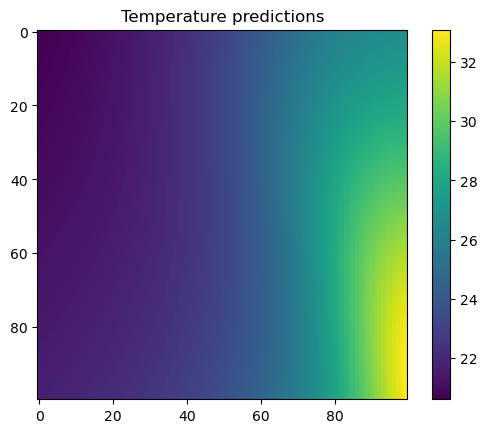

In [667]:
plt.imshow(temps)#, vmin=20, vmax=35)
plt.colorbar()

#plt.set_xticks(ta02_vals[::10])
#plt.xticks(ta02_vals[::10])

# plt.xlabel('TA01, %')
# plt.ylabel('TA02, %')

plt.title('Temperature predictions')
plt.show()

In [668]:
temp_dc

array([25.01, 24.31, 24.88, 24.97, 25.32, 24.79, 25.31, 26.03, 25.77,
       26.57, 26.61, 26.91, 27.56, 27.88, 27.61, 28.33, 27.74, 27.39])

In [669]:
temp_out

array([23.57, 23.79, 24.01, 24.31, 24.48, 24.64, 24.75, 24.92, 25.1 ,
       25.24, 25.42, 25.61, 25.81, 26.04, 26.29, 26.48, 26.67, 26.83])